---
title: DO NOT USE FOR REPURPOSING - DNA score prediction with Pytorch
author: Erin Wilson
date: 2025-03-25
date-modified: last-modified
categories:
  - gene46100
  - notebook
execute:
  eval: false
draft: true 
---

Pytorch tutorial using DNA created by Erin Wilson. Downloaded from [here](https://github.com/erinhwilson/dna-pytorch-tutorial). Minor edits by Haky Im for compatibility with Apple Silicon (M1/M2/M3) MacBooks using MPS

Key changes:
1. Using float32 instead of float64 (MPS doesn't support double precision)
2. Setting device to 'mps' when available
3. Ensuring tensor data types are compatible with Metal Performance Shaders (MPS)

These modifications ensure compatibility with Apple's built-in GPU acceleration while maintaining compatibility with other systems (CUDA, CPU).

Below is the environment by erinhwilson but not recommended here,   we use %pip, which yielded fewer version incompatibility issues


# Environment Setup

Original environment used conda (not recommended):
conda create -n dna python=3
conda install -c anaconda numpy pandas seaborn scikit-learn jupyter
conda install -c conda-forge matplotlib altair
conda install pytorch
conda install -c bioconda logomaker

We use minimal conda environment gene41600 and install python packages with  `%pip` instead due to fewer version conflicts, especially for M-series Macs. See installation steps below.

In [ ]:
if False:
    %pip install seaborn matplotlib logomaker

if False: # these were installed with the intro notebook
    %pip install scikit-learn plotnine tqdm pandas
    %pip install numpy ## gets installed with scikit-learn
    %pip install tqdm
    %pip install torch
    %pip install torchvision torchmetrics
    

# Build a Pytorch model to predict a score from a DNA sequence
This tutorial shows an example of a Pytorch framework that can use raw DNA sequences as input, feed these into a neural network model, and predict a quantitative label directly from the sequence. 

__Tutorial Overview:__
1. [Generate synthetic DNA data](#s1)
1. [Prepare data for Pytorch training](#s2)
1. [Define Pytorch models](#s3)
1. [Define training loop functions](#s4)
1. [Run the models](#s5)
1. [Check model predictions on test set](#s6)
1. [Visualize convolutional filters](#s7)
1. [Conclusion](#s8)

Some concepts we want to make sure everyone undertstands before we start:
* What is a neural network?
  * Basics of a convolutional neural network (CNN)
  
* Model training over epochs
* Splitting data into train/val/test sets
* Loss functions and comparing train vs val loss curves

These genomics concepts are also important:
* DNA nucleotides and DNA Sequence Representation with one-hot encoding
* What is a regulatory motif?
* Visualizing DNA motifs

__Note:__ The following methods aren't necessarily the *optimal* way to do this - I'm sure there are more elegant solutions! But when I was first learning Pytorch, I had trouble finding a clear "beginner example" and spent a lot of time looking through other more complex codebases. If you're just getting started with Pytorch and are also using DNA sequences as your input, perhaps this tutorial can be a helpful example of how to "connect some Pytorch tubes together" in the context of DNA sequence analysis!

In [4]:
from collections import defaultdict
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
from torch import nn


if torch.backends.mps.is_available():
    torch.set_default_dtype(torch.float32)
    # For NumPy, you can either:
    # Option 1: Set default float type globally
    # np.float_default = np.float32
    # Option 2: Or more commonly, use this when creating arrays:
    # np.array([1,2,3], dtype=np.float32)
    print("Set default to float32 for MPS compatibility")

In [6]:
# Set a random seed in a bunch of different places
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.backends.mps.is_available():
        # For MacBooks with Apple Silicon
        torch.mps.manual_seed(seed)
    elif torch.cuda.is_available():
        # For CUDA GPUs
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")
    
set_seed(17)

Random seed set as 17


Are you working on a GPU? If so, you can put your data/models on `DEVICE` (and have to do so explicity)! If not, you can probably remove all instances of `foo.to(DEVICE)` and it should still work fine on a CPU.


In [7]:
DEVICE = torch.device('mps' if torch.backends.mps.is_available() 
                     else 'cuda' if torch.cuda.is_available() 
                     else 'cpu')
DEVICE

device(type='cpu')

<a id='s1'></a>
## 1. Generate synthetic DNA data

Usually scientists might be interested in predicting something like a binding score, an expression strength, or classifying a TF binding event. But here, we are going to keep it simple: the goal in this tutorial is to observe if a deep learning model can learn to detect a very small, simple pattern in a DNA sequence and score it appropriately (again, just a practice task to convince ourselves that we have actually set up the Pytorch pieces correctly such that it can learn from input that looks like a DNA sequence). 

So arbitrarily, let's say that given an 8-mer DNA sequence, we will score it based on the following rules:
* A = +20 points
* C = +17 points
* G = +14 points
* T = +11 points

For every 8-mer, let's sum up its total points based on the nucleotides in its sequence, then take the average. 
For example, 

* `AAAAAAAA` would score `20.0` 

  *  (`mean(20 + 20 + 20 + 20 + 20 + 20 + 20 + 20) = 20.0`)  


* `ACAAAAAA` would score `19.625` 

  * (`mean(20 + 17 + 20 + 20 + 20 + 20 + 20 + 20) = 19.625`)

These values for the nucleotides are arbitrary - there's no real biology here! It's just a way to assign sequences a score for the purposes of our Pytorch practice.

However, since many recent papers use methods like CNNs to automatically detect "motifs," or short patterns in the DNA that can activate or repress a biological response, let's add one more piece to our scoring system. To simulate something like motifs influencing gene expression, let's say a given sequence gets a `+10` bump if `TAT` appears anywhere in the 8-mer, and a `-10` bump if it has a `GCG` in it. Again, these motifs don't mean anything in real life, they are just a mechanism for simulating a really simple activation or repression effect. 

![](images/scoring.png)

So let's implement this basic scoring function!

In [8]:
def kmers(k):
    '''Generate a list of all k-mers for a given k'''
    
    return [''.join(x) for x in product(['A','C','G','T'], repeat=k)]

In [9]:
seqs8 = kmers(8)
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [10]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
                  
def score_seqs_motif(seqs):
    '''
    Calculate the scores for a list of sequences based on 
    the above score_dict
    '''
    data = []
    for seq in seqs:
        # get the average score by nucleotide
        score = np.mean([score_dict[base] for base in seq],dtype=np.float32)
        
        # give a + or - bump if this k-mer has a specific motif
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df

In [11]:
mer8 = score_seqs_motif(seqs8)
mer8.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


Spot check scores of a couple seqs with motifs:

In [12]:
mer8[mer8['seq'].isin(['TGCGTTTT','CCCCCTAT'])]

,seq,score
21875,CCCCCTAT,25.875
59135,TGCGTTTT,2.500


As expected, the distribution of scores across all 8-mers has 3 groups:
* No motif (centered around ~15)
* contains `TAT` (~25)
* contains `GCG` (~5)

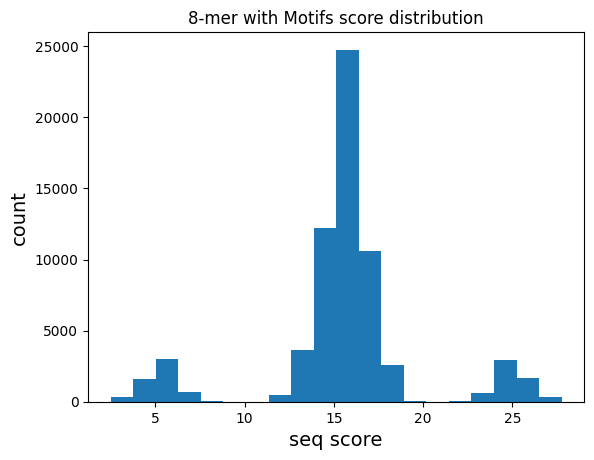

In [13]:
plt.hist(mer8['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

Our goal is now to train a model to predict this score by looking at the DNA sequence.

## Question 1

Modify the scoring function to create a more complex pattern. Instead of giving fixed bonuses for "TAT" and "GCG", implement a position-dependent scoring where a motif gets a higher bonus if it appears at the beginning of the sequence compared to the end. How does this change the distribution of scores?
   

<a id='s2'></a>
## 2. Prepare data for Pytorch training

For neural networks to make predictions, you have to give it your input as a matrix of numbers. For example, to classify images by whether or not they contain a cat, a network "sees" the image as a matrix of pixel values and learns relevant patterns in the relative arrangement of pixels (e.g. patterns that correspond to cat ears, or a nose with whiskers). 

We similarly need to turn our DNA sequences (strings of ACGTs) into a matrix of numbers. So how do we pretend our DNA is a cat? 

One common strategy is to one-hot encode the DNA: treat each nucleotide as a vector of length 4, where 3 positions are 0 and one position is a 1, depending on the nucleotide.

![](images/cat.png)

This one-hot encoding has the nice property that it makes your DNA appear like how a computer sees a picture of a cat!

In [14]:
def one_hot_encode(seq):
    """
    Given a DNA sequence, return its one-hot encoding
    """
    # Make sure seq has only allowed bases
    allowed = set("ACTGN")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence contains chars not in allowed DNA alphabet (ACGTN): {invalid}")
        
    # Dictionary returning one-hot encoding for each nucleotide 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'T':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Create array from nucleotide sequence
    vec=np.array([nuc_d[x] for x in seq], dtype=np.float32)
        
    return vec

In [15]:
# look at DNA seq of 8 As
a8 = one_hot_encode("AAAAAAAA")
print("AAAAAA:\n",a8)

# look at DNA seq of random nucleotides
s = one_hot_encode("AGGTACCT")
print("AGGTACC:\n",s)
print("shape:",s.shape)

AAAAAA:
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
AGGTACC:
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
shape: (8, 4)


With this one-hot encoding scheme, we can prepare our train, val, and test sets. This `quick_split` just randomly picks some indices in the pandas dataframe to split (sklearn has a function to do this too). 

_Note: In real/non-synthetic tasks, you might need to be more clever about your splitting strategy depending on your prediction task: often papers will create train/test splits by chromosome or other genome location features_

In [16]:
def quick_split(df, split_frac=0.8, verbose=False):
    '''
    Given a df of samples, randomly split indices between
    train and test at the desired fraction
    '''
    cols = df.columns # original columns, use to clean up reindexed cols
    df = df.reset_index()

    # shuffle indices
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    # split shuffled index list by split_frac
    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split dfs and return
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df[cols], test_df[cols]

In [17]:
full_train_df, test_df = quick_split(mer8)
train_df, val_df = quick_split(full_train_df)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

train_df.head()

Train: (41942, 2)
Val: (10486, 2)
Test: (13108, 2)


,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACC,19.250


In [18]:
def plot_train_test_hist(train_df, val_df,test_df,bins=20):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label='train',alpha=0.5)
    plt.hist(val_df['score'].values,bins=bins,label='val',alpha=0.75)
    plt.hist(test_df['score'].values,bins=bins,label='test',alpha=0.4)
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

With the below histogram, we can confirm that the train, test, and val sets contain example sequences from each bucket of the distribution (each set has some examples with each kind of motif)

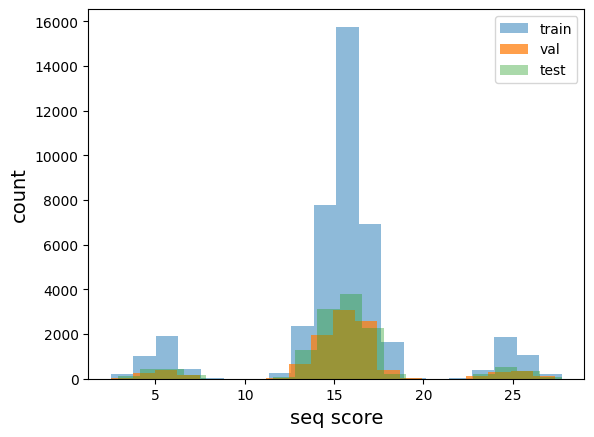

In [137]:
plot_train_test_hist(train_df, val_df,test_df)

A big step here when preparing your data for Pytorch is using [DataLoader and Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) objects. It took me a lot of googling around to figure something out, but this is a solution I was able to concoct from a lot of combing through docs and stack overflow posts!

In short, a Dataset wraps your data in an object that can smoothly give your properly formatted X examples and Y labels to the model you're training. The DataLoader accepts a Dataset and some other details about how to form batches from your data and makes it easier to iterate through training steps.

In [19]:
from torch.utils.data import Dataset, DataLoader

#### Here is a custom defined Dataset object specialized for one-hot encoded DNA:


In [20]:
class SeqDatasetOHE(Dataset):
    '''
    Dataset for one-hot-encoded sequences
    '''
    def __init__(self,
                 df,
                 seq_col='seq',
                 target_col='score'
                ):
        # +--------------------+
        # | Get the X examples |
        # +--------------------+
        # extract the DNA from the appropriate column in the df
        self.seqs = list(df[seq_col].values)
        self.seq_len = len(self.seqs[0])
        
        # one-hot encode sequences, then stack in a torch tensor
        self.ohe_seqs = torch.stack([torch.tensor(one_hot_encode(x)) for x in self.seqs])
    
        # +------------------+
        # | Get the Y labels |
        # +------------------+
        self.labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        # Given an index, return a tuple of an X with it's associated Y
        # This is called inside DataLoader
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        
        return seq, label

#### Here is how I constructed DataLoaders from Datasets. 

In [21]:
def build_dataloaders(train_df,
                      test_df,
                      seq_col='seq',
                      target_col='score',
                      batch_size=128,
                      shuffle=True
                     ):
    '''
    Given a train and test df with some batch construction
    details, put them into custom SeqDatasetOHE() objects. 
    Give the Datasets to the DataLoaders and return.
    '''
    
    # create Datasets    
    train_ds = SeqDatasetOHE(train_df,seq_col=seq_col,target_col=target_col)
    test_ds = SeqDatasetOHE(test_df,seq_col=seq_col,target_col=target_col)

    # Put DataSets into DataLoaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    
    return train_dl,test_dl

In [22]:
train_dl, val_dl = build_dataloaders(train_df, val_df)

These dataloaders are now ready to be used in a training loop!

<a id='s3'></a>
## 3. Define Pytorch models
The primary model I was interested in trying was a Convolutional Neural Network, as these have been shown to be useful for learning motifs from genomic data. But as a point of comparison, I included a simple Linear model. Here are some model definitions:

In [23]:
# very simple linear model
class DNA_Linear(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        # the 4 is for our one-hot encoded vector length 4!
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        return out

    
# basic CNN model
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            # 4 is for the 4 nucleotides
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 1)
        ) 

    def forward(self, xb):
        # reshape view to batch_size x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.permute(0,2,1) 
        
        #print(xb.shape)
        out = self.conv_net(xb)
        return out
    
    # __FOOTNOTE 1__


class DNA_CNN2(nn.Module):
    def __init__(self, seq_len, num_filters=32, kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        # Define layers individually
        self.conv = nn.Conv1d(4, num_filters, kernel_size=kernel_size)
        self.linear = nn.Linear(num_filters*(seq_len-kernel_size+1), 1)

    def forward(self, xb):
        # reshape view to batch_size x 4channel x seq_len
        xb = xb.permute(0, 2, 1)
        
        # Apply layers step by step
        x = self.conv(xb)
        x = F.relu(x, inplace=True)
        x = x.flatten(1)  # flatten all dimensions except batch
        out = self.linear(x)
        return out 

These aren't optimized models, just something to start with (again, we're just practicing connecting the Pytorch tubes in the context of DNA!). 
* The Linear model tries to predict the score by simply weighting the nucleotides that appears in each position.
* The CNN model uses 32 filters of length (`kernel_size`) 3 to scan across the 8-mer sequences for informative 3-mer patterns.

<a id='s4'></a>
## 4. Define the training loop functions
Next, we need to define the training/fit loop. I admit I'm not _super_ confident here and spent a lot of time wading through matrix dimension mismatch errors - there are likely more elegant ways to do this! But maybe this is ok? -*shrug*- (Shoot me a message if you have feedback :) )

In any case, I defined functions that stack like this:

```python 
# adds default optimizer and loss function
run_model()
    # loops through epochs
    fit()
        # loop through batches
        train_step()
            # calc train loss for batch
            loss_batch()
        val_step()
            # calc val loss for batch
            loss_batch()
```

In [24]:
# +--------------------------------+
# | Training and fitting functions |
# +--------------------------------+

def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    # get the batch output from the model given your input batch 
    # ** This is the model's prediction for the y labels! **
    xb_out = model(xb.float())
    
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    loss = loss_func(xb_out, yb.float()) # for MSE/regression
    # __FOOTNOTE 2__
    
    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def train_step(model, train_dl, loss_func, device, opt):
    '''
    Execute 1 set of batched training within an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    
    # loop through train DataLoader
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(device),yb.to(device)
        
        # provide opt so backprop happens
        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        
        # collect train loss and batch sizes
        tl.append(t)
        ns.append(n)
    
    # average the losses over all batches    
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    
    return train_loss

def val_step(model, val_dl, loss_func, device):
    '''
    Execute 1 set of batched validation within an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes, n
        
        # loop through validation DataLoader
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(device),yb.to(device)

            # Do NOT provide opt here, so backprop does not happen
            v, n = loss_batch(model, loss_func, xb, yb)

            # collect val loss and batch sizes
            vl.append(v)
            ns.append(n)

    # average the losses over all batches
    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    
    return val_loss


def fit(epochs, model, loss_func, opt, train_dl, val_dl,device,patience=1000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loop through epochs
    for epoch in range(epochs):
        # take a training step
        train_loss = train_step(model,train_dl,loss_func,device,opt)
        train_losses.append(train_loss)

        # take a validation step
        val_loss = val_step(model,val_dl,loss_func,device)
        val_losses.append(val_loss)
        
        print(f"E{epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")

    return train_losses, val_losses


def run_model(train_dl,val_dl,model,device,
              lr=0.01, epochs=50, 
              lossf=None,opt=None
             ):
    '''
    Given train and val DataLoaders and a NN model, fit the mode to the training
    data. By default, use MSE loss and an SGD optimizer
    '''
    # define optimizer
    if opt:
        optimizer = opt
    else: # if no opt provided, just use SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # define loss function
    if lossf:
        loss_func = lossf
    else: # if no loss function provided, just use MSE
        loss_func = torch.nn.MSELoss()
    
    # run the training loop
    train_losses, val_losses = fit(
                                epochs, 
                                model, 
                                loss_func, 
                                optimizer, 
                                train_dl, 
                                val_dl, 
                                device)

    return train_losses, val_losses


<a id='s5'></a>
## 5. Run the models
First let's try running a Linear Model on our 8-mer sequences

In [25]:
# get the sequence length from the first seq in the df
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_lin = DNA_Linear(seq_len)
# use float32 since mps cannot handle 64
model_lin = model_lin.type(torch.float32)
model_lin.to(DEVICE) # put on GPU


# run the model with default settings!
lin_train_losses, lin_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_lin,
    DEVICE
)

E0 | train loss: 21.238 | val loss: 12.980
E1 | train loss: 12.969 | val loss: 12.826
E2 | train loss: 12.918 | val loss: 12.832
E3 | train loss: 12.915 | val loss: 12.847
E4 | train loss: 12.916 | val loss: 12.833
E5 | train loss: 12.918 | val loss: 12.837
E6 | train loss: 12.915 | val loss: 12.828
E7 | train loss: 12.917 | val loss: 12.826
E8 | train loss: 12.917 | val loss: 12.827
E9 | train loss: 12.917 | val loss: 12.827
E10 | train loss: 12.918 | val loss: 12.831
E11 | train loss: 12.914 | val loss: 12.836
E12 | train loss: 12.918 | val loss: 12.834
E13 | train loss: 12.916 | val loss: 12.830
E14 | train loss: 12.917 | val loss: 12.832
E15 | train loss: 12.917 | val loss: 12.831
E16 | train loss: 12.917 | val loss: 12.833
E17 | train loss: 12.915 | val loss: 12.882
E18 | train loss: 12.916 | val loss: 12.834
E19 | train loss: 12.916 | val loss: 12.833
E20 | train loss: 12.917 | val loss: 12.830
E21 | train loss: 12.918 | val loss: 12.830
E22 | train loss: 12.917 | val loss: 12.82

Let's look at the loss in quick plot:

In [26]:
def quick_loss_plot(data_label_list,loss_type="MSE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,(train_data,test_data,label) in enumerate(data_label_list):    
        plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Val",linewidth=3.0)

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

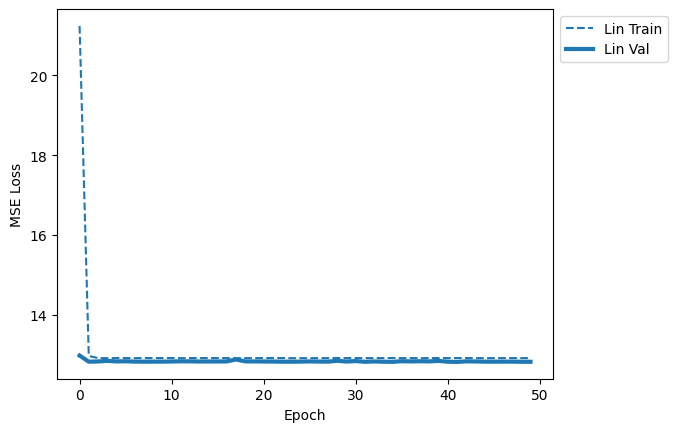

In [30]:
lin_data_label = (lin_train_losses,lin_val_losses,"Lin")
quick_loss_plot([lin_data_label])

At first glance, not much learning appears to be happening. 

Next let's try the CNN.

In [27]:
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_cnn = DNA_CNN(seq_len)
model_cnn.to(DEVICE) # put on GPU

# run the model with default settings!
cnn_train_losses, cnn_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_cnn,
    DEVICE
)

E0 | train loss: 14.640 | val loss: 10.167
E1 | train loss: 8.625 | val loss: 7.035
E2 | train loss: 6.305 | val loss: 4.965
E3 | train loss: 4.507 | val loss: 3.267
E4 | train loss: 3.118 | val loss: 2.280
E5 | train loss: 2.419 | val loss: 2.693
E6 | train loss: 1.996 | val loss: 2.415
E7 | train loss: 1.825 | val loss: 3.567
E8 | train loss: 1.542 | val loss: 1.295
E9 | train loss: 1.451 | val loss: 1.189
E10 | train loss: 1.225 | val loss: 1.107
E11 | train loss: 1.205 | val loss: 1.135
E12 | train loss: 1.146 | val loss: 1.104
E13 | train loss: 1.028 | val loss: 1.108
E14 | train loss: 1.030 | val loss: 1.204
E15 | train loss: 1.037 | val loss: 1.115
E16 | train loss: 1.036 | val loss: 1.039
E17 | train loss: 1.000 | val loss: 1.051
E18 | train loss: 0.968 | val loss: 1.069
E19 | train loss: 0.945 | val loss: 1.174
E20 | train loss: 0.945 | val loss: 1.170
E21 | train loss: 0.926 | val loss: 1.039
E22 | train loss: 0.929 | val loss: 1.257
E23 | train loss: 0.937 | val loss: 1.021


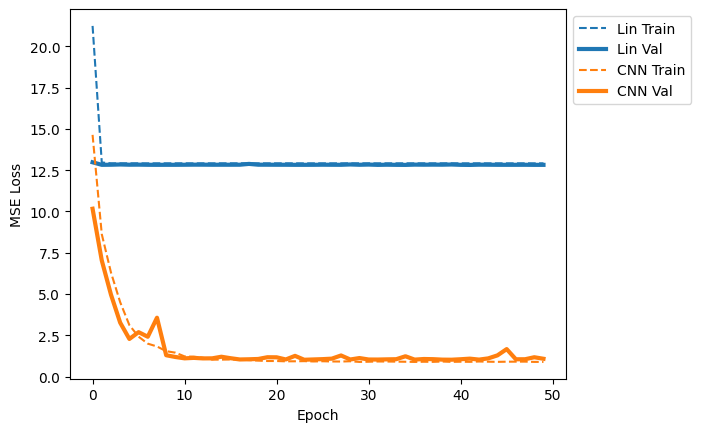

In [31]:
cnn_data_label = (cnn_train_losses,cnn_val_losses,"CNN")
quick_loss_plot([lin_data_label,cnn_data_label])

It seems clear from the loss curves that the CNN is able to capture a pattern in the data that the Linear model is not! Let's spot check a few sequences to see what's going on.

In [32]:
# oracle dict of true score for each seq
oracle = dict(mer8[['seq','score']].values)

def quick_seq_pred(model, desc, seqs, oracle):
    '''
    Given a model and some sequences, get the model's predictions
    for those sequences and compare to the oracle (true) output
    '''
    print(f"__{desc}__")
    for dna in seqs:
        s = torch.tensor(one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = pred.item() - actual
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

def quick_8mer_pred(model, oracle):
    seqs1 = ("poly-X seqs",['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT'])
    seqs2 = ("other seqs", ['AACCAACA','CCGGTGAG','GGGTAAGG', 'TTTCGTTT'])
    seqsTAT = ("with TAT motif", ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT'])
    seqsGCG = ("with GCG motif", ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT'])
    TATGCG =  ("both TAT and GCG",['ATATGCGA','TGCGTATT'])

    for desc,seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        quick_seq_pred(model, desc, seqs, oracle)
        print()

In [33]:
# Ask the trained Linear model to make 
# predictions for some 8-mers
quick_8mer_pred(model_lin, oracle)

__poly-X seqs__
AAAAAAAA: pred:23.415 actual:20.000 (3.415)
CCCCCCCC: pred:13.762 actual:17.000 (-3.238)
GGGGGGGG: pred:7.189 actual:14.000 (-6.811)
TTTTTTTT: pred:17.841 actual:11.000 (6.841)

__other seqs__
AACCAACA: pred:18.987 actual:18.875 (0.112)
CCGGTGAG: pred:12.330 actual:15.125 (-2.795)
GGGTAAGG: pred:14.006 actual:15.125 (-1.119)
TTTCGTTT: pred:14.945 actual:12.125 (2.820)

__with TAT motif__
TATAAAAA: pred:22.317 actual:27.750 (-5.433)
CCTATCCC: pred:17.059 actual:25.875 (-8.816)
GTATGGGG: pred:12.329 actual:24.000 (-11.671)
TTTATTTT: pred:18.331 actual:22.125 (-3.794)

__with GCG motif__
AAGCGAAA: pred:16.972 actual:8.125 (8.847)
CGCGCCCC: pred:12.467 actual:6.250 (6.217)
GGGCGGGG: pred:8.121 actual:4.375 (3.746)
TTGCGTTT: pred:13.014 actual:2.500 (10.514)

__both TAT and GCG__
ATATGCGA: pred:15.874 actual:15.875 (-0.001)
TGCGTATT: pred:14.779 actual:13.625 (1.154)



From the above examples, it appears that the Linear model is really underpredicting sequences with a lot of G's and overpredicting those with many T's. This is probably because it noticed `GCG` made sequences have unusually low scores and `TAT` made sequences have unusually high scores, however since the Linear model doesn't have a way to take into account the different context of `GCG` vs `GAG`, it just predicts that sequences with G's should be lower. We know from our scoring scheme that this isn't the case: it's not that G's in general are detrimental, but **specifically** `GCG` is. 

In [34]:
# Ask the trained CNN model to make 
# predictions for some 8-mers
quick_8mer_pred(model_cnn, oracle)

__poly-X seqs__
AAAAAAAA: pred:19.629 actual:20.000 (-0.371)
CCCCCCCC: pred:16.705 actual:17.000 (-0.295)
GGGGGGGG: pred:13.571 actual:14.000 (-0.429)
TTTTTTTT: pred:10.887 actual:11.000 (-0.113)

__other seqs__
AACCAACA: pred:18.592 actual:18.875 (-0.283)
CCGGTGAG: pred:14.767 actual:15.125 (-0.358)
GGGTAAGG: pred:15.091 actual:15.125 (-0.034)
TTTCGTTT: pred:11.759 actual:12.125 (-0.366)

__with TAT motif__
TATAAAAA: pred:26.081 actual:27.750 (-1.669)
CCTATCCC: pred:24.200 actual:25.875 (-1.675)
GTATGGGG: pred:22.796 actual:24.000 (-1.204)
TTTATTTT: pred:20.518 actual:22.125 (-1.607)

__with GCG motif__
AAGCGAAA: pred:9.008 actual:8.125 (0.883)
CGCGCCCC: pred:7.093 actual:6.250 (0.843)
GGGCGGGG: pred:5.264 actual:4.375 (0.889)
TTGCGTTT: pred:3.397 actual:2.500 (0.897)

__both TAT and GCG__
ATATGCGA: pred:15.341 actual:15.875 (-0.534)
TGCGTATT: pred:13.181 actual:13.625 (-0.444)



The CNN however is better able to adapt to the differences between 3-mer motifs! It predicts quite well on both the sequences with and without motifs. 

## Question 2

Compare the performance of the Linear and CNN models by using different learning rates. First run both models with higher learning rates (0.05, 0.1) and lower learning rates (0.005, 0.001), then create loss plots showing:
   - Linear model with these learning rates
   - CNN model with these learning rates

Then analyze your results by answering:
1. How does changing the learning rate affect convergence for each model?
2. Which model is more sensitive to learning rate changes, and why?
3. Based on your analysis, what learning rate would you recommend for each model type, and why?


<a id='s6'></a>
## 6. Check model predictions on the test set
An important evaluation step in machine learning tasks is to check if your model can make good predictions on the test set, which it *never* saw during training. Here, we can use a parity plot to visualize the difference between the actual sequence scores vs the model's predicted scores.

In [35]:
%pip install altair ## datapane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 1.0 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [36]:
import altair as alt
from sklearn.metrics import r2_score
## import datapane as dp ## compatibility issues with pandas version
import os



In [37]:
def parity_plot(model_name,df,r2):
    '''
    Given a dataframe of samples with their true and predicted values,
    make a scatterplot.
    '''
    plt.scatter(df['truth'].values, df['pred'].values, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.ylim(xpoints)
    plt.ylabel("Predicted Score",fontsize=14)
    plt.xlabel("Actual Score",fontsize=14)
    plt.title(f"{model_name} (r2:{r2:.3f})",fontsize=20)
    plt.show()


def alt_parity_plot(model, df, r2, datapane=False):
    '''
    Make an interactive parity plot with altair
    '''
    import os
    import altair as alt
    
    os.makedirs('alt_out', exist_ok=True)
    
    # Convert model name to string to avoid any issues
    model = str(model)
    
    # Create a clean version of the dataframe
    plot_df = pd.DataFrame({
        'truth': df['truth'].astype(float),
        'pred': df['pred'].astype(float),
        'seq': df['seq'].astype(str)
    })
    
    # Create chart
    chart = alt.Chart(plot_df).mark_point().encode(
        x=alt.X('truth', type='quantitative', title='True Values'),
        y=alt.Y('pred', type='quantitative', title='Predictions'),
        tooltip=['seq']
    ).properties(
        title=str(f'{model} (r2:{r2:.3f})')
    )
    
    chart.save(f'alt_out/parity_plot_{model}.html')
    display(chart)

# def alt_parity_plot(model, df, r2, datapane=False):
#     '''
#     Make an interactive parity plot with altair
#     '''
#     import os
#     import altair as alt
    
#     # Debug: Print data info
#     print("DataFrame info:")
#     print(df.dtypes)
#     print("\nFirst few rows:")
#     print(df.head())
    
#     os.makedirs('alt_out', exist_ok=True)
    
#     # Convert model name to string to avoid any issues
#     model = str(model)
    
#     # Create a clean version of the dataframe
#     plot_df = pd.DataFrame({
#         'truth': df['truth'].astype(float),
#         'pred': df['pred'].astype(float),
#         'seq': df['seq'].astype(str)
#     })
    
#     # Create chart with simplified specification
#     chart = alt.Chart(plot_df).mark_point().encode(
#         x=alt.X('truth', type='quantitative', title='True Values'),
#         y=alt.Y('pred', type='quantitative', title='Predictions'),
#         tooltip=['seq']
#     ).properties(
#         title=str(f'{model} (r2:{r2:.3f})')
#     )
    
#     # Try to display and save
#     try:
#         chart.save(f'alt_out/parity_plot_{model}.html')
#         display(chart)
#     except Exception as e:
#         print(f"Error saving/displaying chart: {e}")


    
# def alt_parity_plot(model,df, r2,datapane=False):
#     '''
#     Make an interactive parity plot with altair
#     '''
#     chart = alt.Chart(df).mark_circle(size=100,opacity=0.4).encode(
#         alt.X('truth:Q'),
#         alt.Y('pred:Q'),
#         tooltip=['seq:N']
#     ).properties(
#         title=f'{model} (r2:{r2:.3f})',
#     ).interactive()
    
#     chart.save(f'alt_out/parity_plot_{model}.html')
#     display(chart)
    
#     # if datapane:
#     #     report = dp.Report(dp.Plot(chart) ) #Create a report
#     #     report.upload(name=f'dna_pytorch_tutorial_altair_{model}', open=True, visibility='PUBLIC') #Publish the report



def parity_pred(models, seqs, oracle,alt=False,datapane=False):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model in models:
        print(f"Running {model_name}")
        data = []
        for dna in seqs:
            s = torch.tensor(one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            actual = oracle[dna]
            pred = model(s.float())
            data.append([dna,actual,pred.item()])
        df = pd.DataFrame(data, columns=['seq','truth','pred'])
        r2 = r2_score(df['truth'],df['pred'])
        dfs[model_name] = (r2,df)
        
        #plot parity plot
        if alt: # make an altair plot
            alt_parity_plot(model_name, df, r2,datapane=datapane)
            
        else:
            parity_plot(model_name, df, r2)


Running Linear


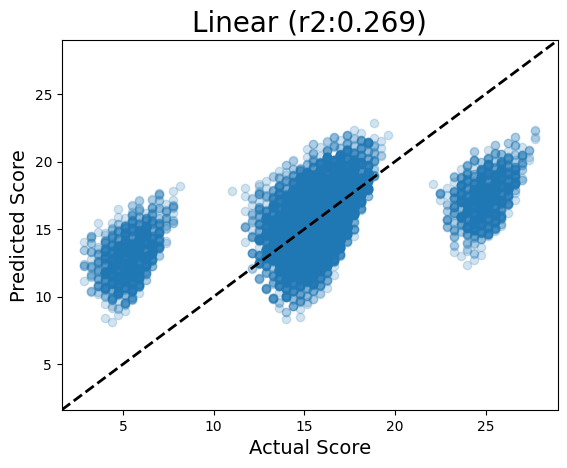

Running CNN


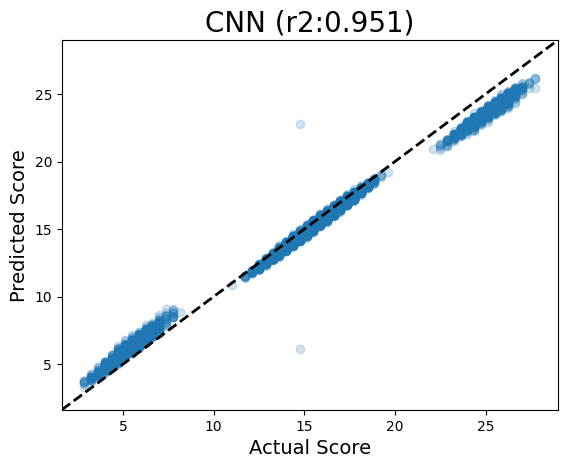

In [38]:
seqs = test_df['seq'].values
models = [
    ("Linear", model_lin),
    ("CNN", model_cnn)
]
parity_pred(models, seqs, oracle)

Parity plots are useful for visualizing how well your model predicts individual sequences: in a perfect model, they would all land on the `y=x` line, meaning that the model prediction was exactly the sequence's actual value. But if it is off the `y=x` line, it means the model is over- or under-predicting. 

In the Linear model, we can see that it can somewhat predict a trend in the Test set sequences, but really gets confused by these buckets of sequences in the high and low areas of the distribution (the ones with a motif). 

However for the CNN, it is much better at predicting scores close to the actual value! This is expected, given that the architecture of our CNN uses 3-mer kernels to scan along the sequence for influential motifs.

But the CNN isn't perfect. We could probably train it longer or adjust the hyperparameters, but the goal here isn't perfection - this is a very simple task relative to actual regulatory grammars. Instead, I thought it would be interesting to use the Altair visualization library to interactively inspect which sequences the models get wrong:

In [39]:
alt.data_transformers.disable_max_rows() # disable altair warning
parity_pred(models, seqs, oracle,alt=True)

Running Linear


alt.Chart(...)

Running CNN


alt.Chart(...)

If you're viewing this notebook in interactive mode and run the above cell (just viewing via the github preview will omit the altair plot in the rendering), you can hover over the points and see the individual 8-mer sequences (you can also pan and zoom in this plot). 

Notice that the sequences that are off the diagonal tend to have *multiple* instance of the motifs! In the scoring function, we only gave the sequence a +/- bump if it had at least 1 motif, but it certainly would have been reasonable to decide to add multiple bonuses if the motif was present multiple times. In this example, I arbitrarily only added the bonus for at least 1 motif occurrence, but we could have made a different scoring function. 

In any case, I thought it was cool that the model noticed the multiple occurrences and predicted them to be important. I suppose we did fool it a little, though an R2 of 0.95 is pretty respectable :) 

<img src="images/altair_hover_render.png" alt="drawing" width="500" align="left"/>

(A quick screenshot of the Altair plot with tooltips from above if you can't see it in the Github preview)

In [197]:
# Compatibility issues with datapane, commented out here
# upload CNN altair viz to Datapane for publishing
# parity_pred([("CNN",model_cnn)], seqs, oracle,alt=True,datapane=True)

## Question 3

Design an approach to improve the model's prediction accuracy, particularly focusing on the sequences where the current model performs poorly:

1. After identifying sequences where the CNN model has high prediction errors, propose and implement a modification to either the model architecture, the loss function, the training process, or the data representation

2. Retrain the model with your modifications

3. Create comparative visualizations (such as parity plots, error histograms, or other appropriate plots) to demonstrate the impact of your changes

4. Analyze your results by discussing how your modification addresses the specific weaknesses you identified. What are the trade-offs involved in your approach?
   

<a id='s7'></a>
## 7. Visualize convolutional filters
When training CNN models, it can be useful to visualize the first layer convolutional filters to try to understand more about what the model is learning. With image data, the first layer convolutional filters often learn patterns such as borders or colors or textures - basic image elements that can be recombined to make more complex features. 

In DNA, convolutional filters can be thought of like motif scanners. Similar to a position weight matrix for visualizing sequence logos, a convolutional filter is like a matrix showing a particular DNA pattern, but instead of being an *exact* sequence, it can hold some uncertainty about which nucleotides show up in which part of the pattern. Some positions might be very certain (i.e., there's always an A in position 2; high information content) while other positions could hold a variety of nucleotides with about equal probability (high entropy; low information content). 

The calculations that occur within the hidden layers of neural networks can get very complex and not every convolutional filter will be an obviously relevant pattern, but sometimes patterns in the filters do emerge and can be informative for helping to explain the model's predictions. 

Below are some functions to visualize the first layer convolutional filters, both as a raw heatmap and as a motif logo. 

In [40]:
import logomaker

In [41]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv1d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv1d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    model_weights = model_weights[0]
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()

First, we can take a peek at the raw filters.

Total convolutional layers: 1


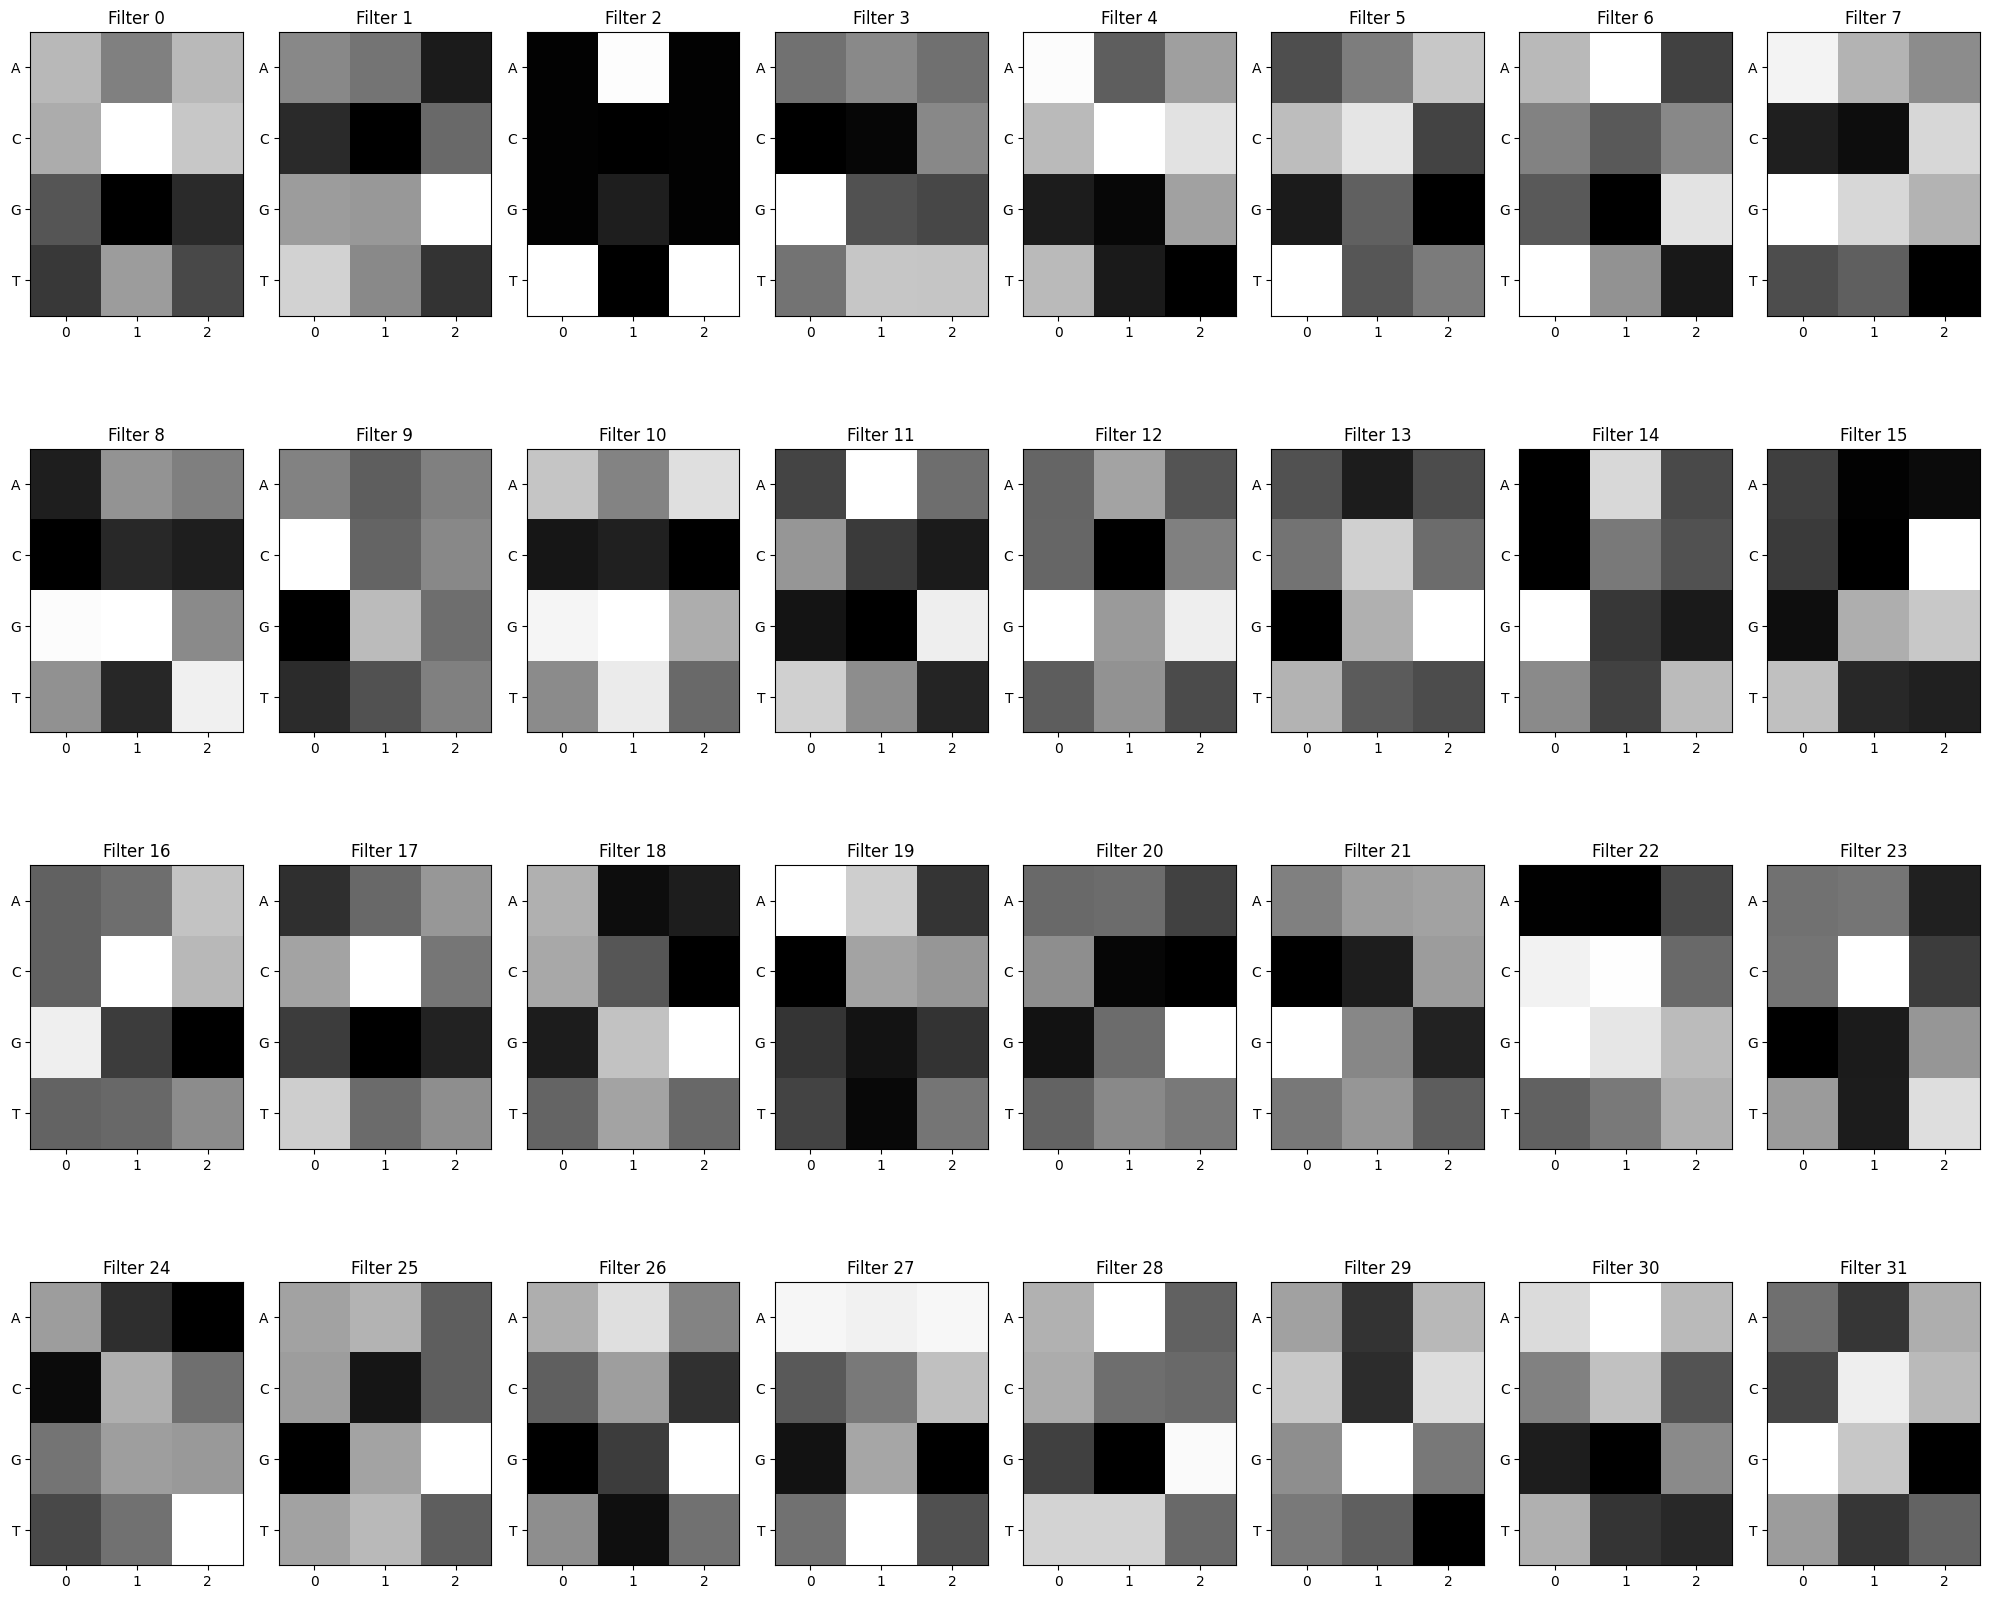

In [42]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(model_cnn)
view_filters(model_weights)

![](images/filter_activation.png)

In [43]:
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce and a convolutional layer, 
    get the output tensor containing the conv filter 
    activations along each position in the sequence
    '''
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(one_hot_encode(seq)).unsqueeze(0).permute(0,2,1).to(DEVICE)

    # run seq through conv layer
    with torch.no_grad(): # don't want as part of gradient graph
        # apply learned filters to input seq
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer,act_thresh=0):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run seq inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were > act_thresh. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter above the threshold act_thresh
    '''
    # initialize dict of pwms for each filter in the conv layer
    # pwm shape: 4 nucleotides X filter width, initialize to 0.0s
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[0]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        # get a tensor of each conv filter activation along the input seq
        res = get_conv_output_for_seq(seq, conv_layer)

        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            # collect the indices where the activation level 
            # was above the threshold
            act_idxs = torch.where(act_vec>act_thresh)[0]
            activated_positions = [x.item() for x in act_idxs]

            # use activated indicies to extract the actual DNA
            # subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                # transpose OHE to match PWM orientation
                subseq_tensor = torch.tensor(one_hot_encode(subseq)).T

                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    '''
    Given some convolutional model weights and filter activation PWMs, 
    visualize the heatmap and motif logo pairs in a simple grid
    '''
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)

    # make sure the model weights agree with the number of filters
    assert(model_weights.shape[0] == len(filter_activations))
    
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 
    # ^ not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 17))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(model_weights.shape[2]))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

Num filters 32
filt_width 3
torch.Size([32, 4, 3])


/opt/anaconda3/envs/gene46100/lib/python3.12/site-packages/logomaker/src/Logo.py:1001: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


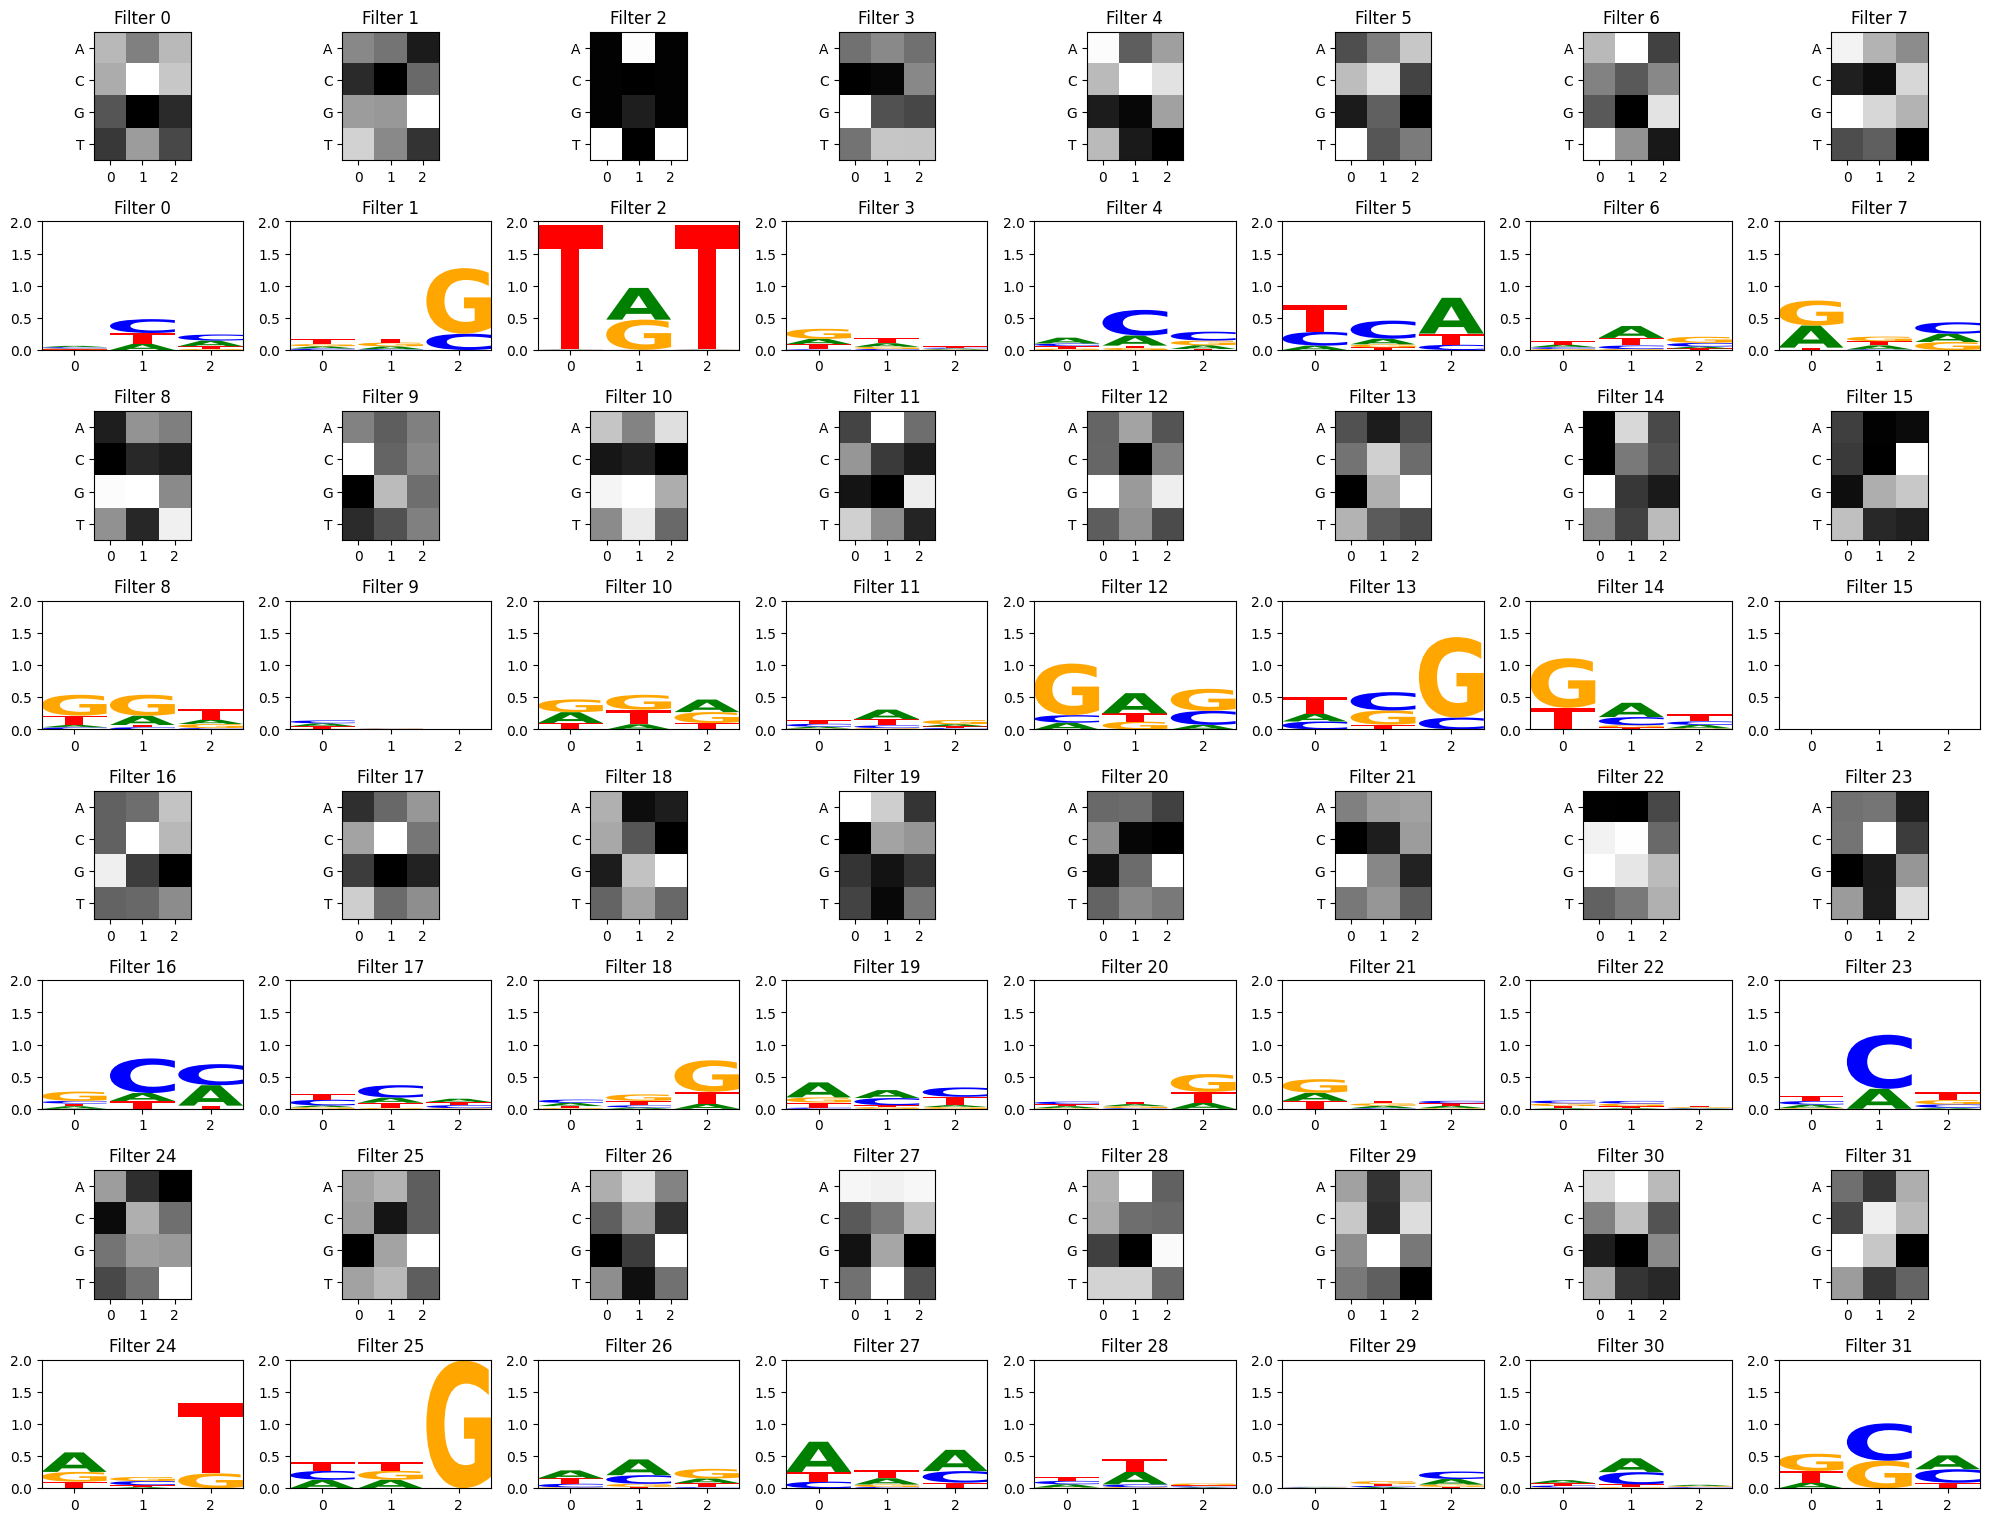

In [44]:
# just use some seqs from test_df to activate filters
some_seqs = random.choices(seqs, k=3000)

filter_activations = get_filter_activations(some_seqs, conv_layers[0])
view_filters_and_logos(model_weights,filter_activations)

### Visualize filters using a stronger activation threshold
`act_thresh = 1` instead of `0`. (Some filters have no subsequence matches above the threshold and result in an empty motif logo)

Num filters 32
filt_width 3
torch.Size([32, 4, 3])


/opt/anaconda3/envs/gene46100/lib/python3.12/site-packages/logomaker/src/Logo.py:1001: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/opt/anaconda3/envs/gene46100/lib/python3.12/site-packages/logomaker/src/Logo.py:1001: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/opt/anaconda3/envs/gene46100/lib/python3.12/site-packages/logomaker/src/Logo.py:1001: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/opt/anaconda3/envs/gene46100/lib/python3.12/site-packages/logomaker/src/Logo.py:1001: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/opt/anaconda3/envs/gene46100/lib/python3.12/site-packag

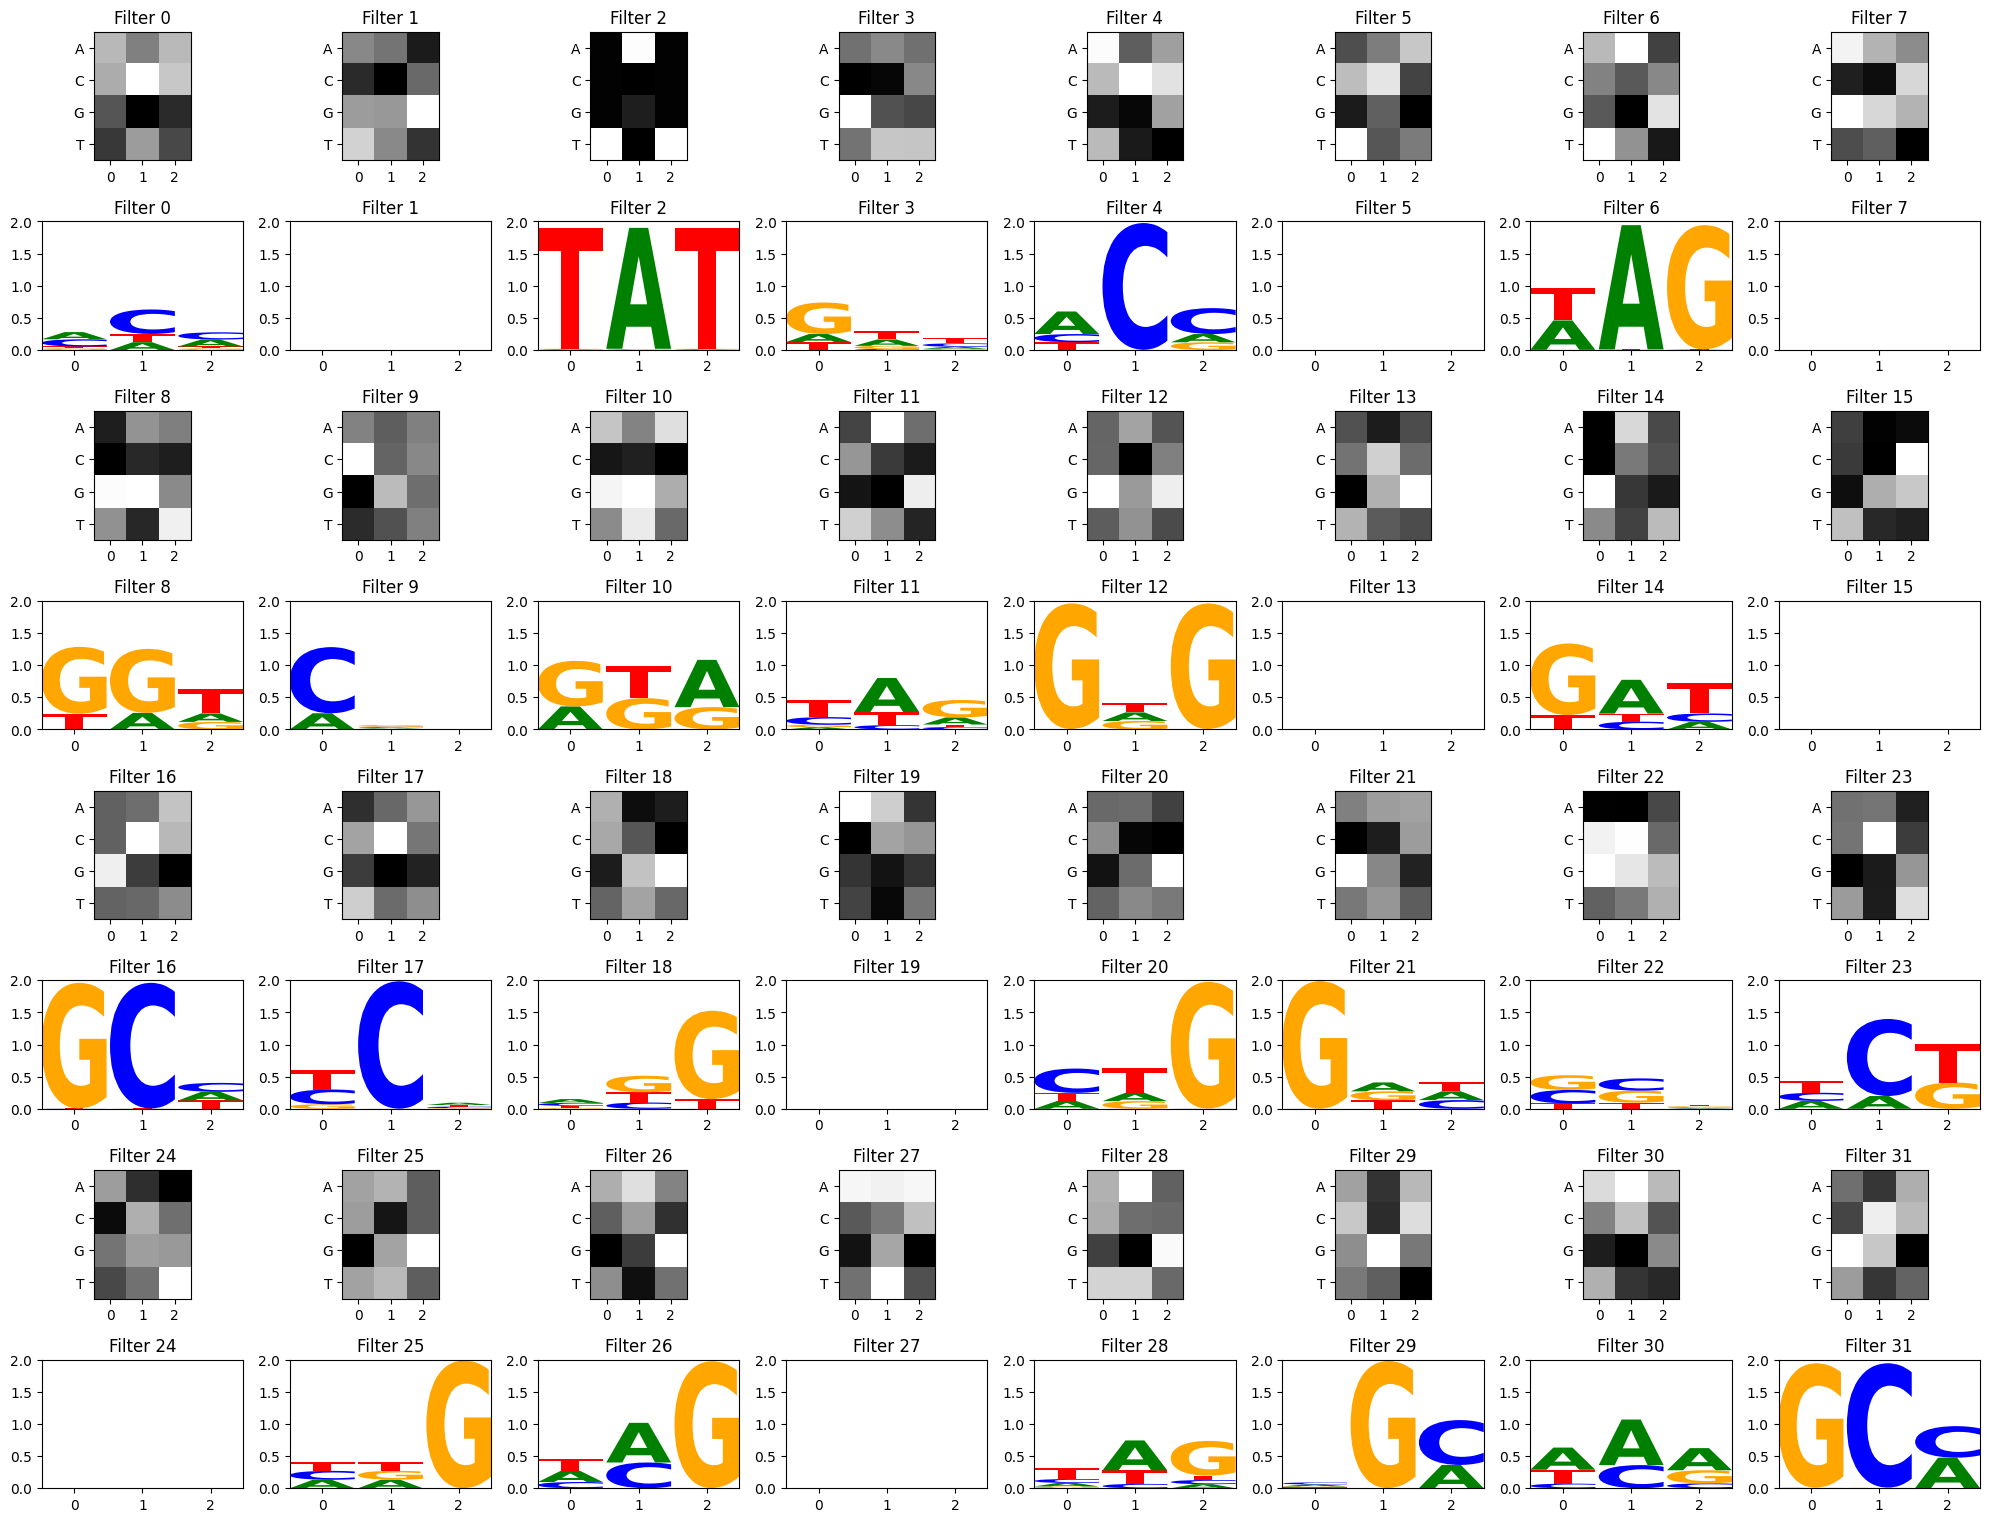

In [45]:
filter_activations = get_filter_activations(some_seqs, conv_layers[0],act_thresh=1)
view_filters_and_logos(model_weights,filter_activations)

From this particular CNN training, we can see a few filters have picked up on the strong TAT and GCG motifs, but other filters have focused on other patterns as well. There is some debate about how relevant convolutional filter visualizations are for model interpretability. In deep models with multiple convolutional layers, convolutional filters can be recombined in more complex ways inside the hidden layers, so the first layer filters may not be as informative on their own ([Koo and Eddy, 2019](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007560)). Much of the field has since moved towards attention mechanisms and other explainability methods, but should you be curious to visualize your filters as potential motifs, these functions may help get you started!

### Question 4

Modify the scoring function in Part 1 to use a longer motif (e.g., change "TAT" to "TATAT" and "GCG" to "GCGCG"). Keep everything else the same (same sequence length, same CNN architecture with kernel_size=3). Train the model and visualize the convolutional filters. Answer these questions in your analysis:

1. Can the model with kernel_size=3 still detect the longer motifs? How?
2. How do the filter visualizations differ from the original 3-base motif case?


<a id='s8'></a>
## 8. Conclusion
This tutorial shows some basic Pytorch structure for building CNN models that work with DNA sequences. The practice task used in this demo is not reflective of real biological signals; rather, we designed the scoring method to simulate the presence of regulatory motifs in very short sequences that were easy for us humans to inspect and verify that Pytorch was behaving as expected. From this small example, we observed how a basic CNN with sliding filters was able to predict our scoring scheme better than a basic linear model that only accounted for absolute nucleotide position (without local context). 

To read more about CNN's applied to DNA in the wild, check out the following foundational papers:
* DeepBind: [Alipanahi et al 2015](https://www.nature.com/articles/nbt.3300)
* DeepSea: [Zhou and Troyanskaya 2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4768299/)
* Basset: [Kelley et al 2016](https://pubmed.ncbi.nlm.nih.gov/27197224/)

I hope other new-to-ML folks interested in tackling biological questions may find this helpful for getting started with using Pytorch to model DNA sequences :) 

## 9. Foot notes
### FOOTNOTE 1
In this tutorial, the CNN model definition uses a 1D convolutional layer - since DNA is not an image with 2 dimensions, Conv1D is sufficient to just slide along the length dimension and not scan up and down. (In fact, sliding a filter "up" and "down" doesn't apply to one-hot encoded DNA matrices: separating the `A` and `C` rows from the `G` and `T` rows doesn't make sense - you need all 4 rows to accurately represent a DNA sequence.)

However, I once found myself needing to use an analysis tool built with keras and found a pytorch2keras conversion script. The conversion script only knew how to handle Conv2d layers and gave errors for models with Conv1d layers :( 

In case this happens to you, here is an example of how to reformat the CNN definition using a Conv2D while ensuring that it still scans along the DNA as if it were a Conv1D:


In [ ]:
class DNA_CNN_2D(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3,
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel, moved 4 to kernel_size
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 1)
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix
        
        #print(xb.shape)
        out = self.conv_net(xb)
        return out

### FOOTNOTE 2
If you're doing a classification task instead of a regression task, you may want to use `CrossEntropyLoss`. However, `CrossEntropyLoss` expects a slightly different format than `MSELoss` - try this:

In [ ]:
loss = loss_func(xb_out, yb.long().squeeze(1))